In [ ]:
# Mount Google Drive for data access
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


Mounted at /content/drive


In [ ]:

# Load and preprocess the new dataset
dataset = pd.read_csv("/content/drive/MyDrive/S.I.R.I.U.S./AMZN.csv")

# Assuming that 'Close' column contains the stock prices
prices = dataset['Close'].values
sc = MinMaxScaler(feature_range=(0, 1))
training_scaled = sc.fit_transform(prices.reshape(-1, 1))

x_train, y_train = [], []
look_back = 60  # Adjust this based on your model's look-back window


In [ ]:

for i in range(look_back, len(training_scaled)):
    x_train.append(training_scaled[i-look_back:i, 0])
    y_train.append(training_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
regressor.add(Dropout(0.2))

for _ in range(3):  # Add three more LSTM layers with Dropout
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))  # Final LSTM layer
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))  # Output layer
regressor.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:

# Train the model
history = regressor.fit(x_train, y_train, epochs=25, batch_size=1024, verbose=1, validation_split=0.1)


Epoch 1/25
6/6 [==============================] - 13s 2s/step - loss: 3.7532e-04 - val_loss: 0.0050
Epoch 2/25
6/6 [==============================] - 12s 2s/step - loss: 3.2172e-04 - val_loss: 0.0034
Epoch 3/25
6/6 [==============================] - 12s 2s/step - loss: 3.2998e-04 - val_loss: 0.0035
Epoch 4/25
6/6 [==============================] - 12s 2s/step - loss: 2.9990e-04 - val_loss: 0.0047
Epoch 5/25
6/6 [==============================] - 13s 2s/step - loss: 3.0546e-04 - val_loss: 0.0044
Epoch 6/25
6/6 [==============================] - 15s 3s/step - loss: 3.0068e-04 - val_loss: 0.0035
Epoch 7/25
6/6 [==============================] - 12s 2s/step - loss: 3.0601e-04 - val_loss: 0.0037
Epoch 8/25
6/6 [==============================] - 11s 2s/step - loss: 2.9319e-04 - val_loss: 0.0043
Epoch 9/25
6/6 [==============================] - 12s 2s/step - loss: 2.8726e-04 - val_loss: 0.0042
Epoch 10/25
6/6 [==============================] - 12s 2s/step - loss: 2.9244e-04 - val_loss: 0.0039

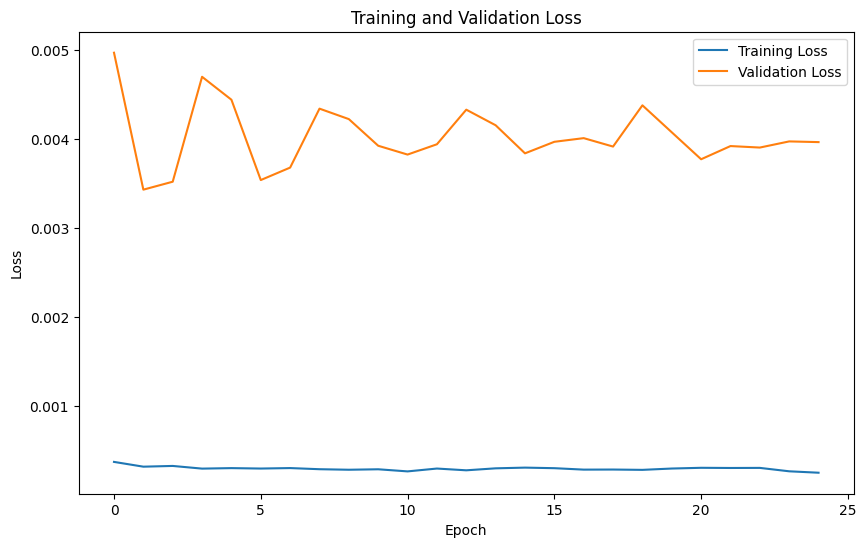

In [ ]:

# Visualize training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
# Prepare input data for prediction
inputs = dataset['Close'].values
inputs = inputs[len(inputs) - len(x_train) - look_back:]
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

x_test = []
for i in range(look_back, len(inputs)):
    x_test.append(inputs[i-look_back:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))



In [ ]:
# Predict stock prices
predicted_price = regressor.predict(x_test)
predicted_price = sc.inverse_transform(predicted_price)

# Display the last few real and predicted prices
print("Last 10 Real Stock Prices:\n", prices[-10:])
print("\nLast 10 Predicted Stock Prices:\n", predicted_price[-10:])

200/200 [==============================] - 14s 55ms/step
Last 10 Real Stock Prices:
 [92.41999817 96.54000092 95.5        94.12999725 91.01000214 88.25
 88.45999908 90.34999847 89.08999634 88.50499725]

Last 10 Predicted Stock Prices:
 [[98.24856 ]
 [97.712135]
 [97.24256 ]
 [96.83544 ]
 [96.48661 ]
 [96.18822 ]
 [95.92681 ]
 [95.68638 ]
 [95.452415]
 [95.2134  ]]


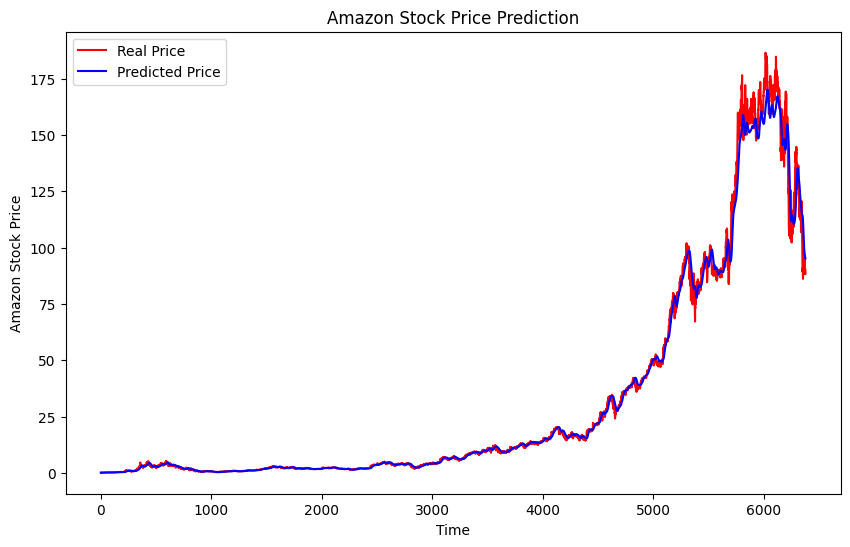

In [ ]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(prices[-len(predicted_price):], color='red', label='Real Price')
plt.plot(predicted_price, color='blue', label='Predicted Price')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.show()

Mean Absolute Error (MAE): 43.42389957179967


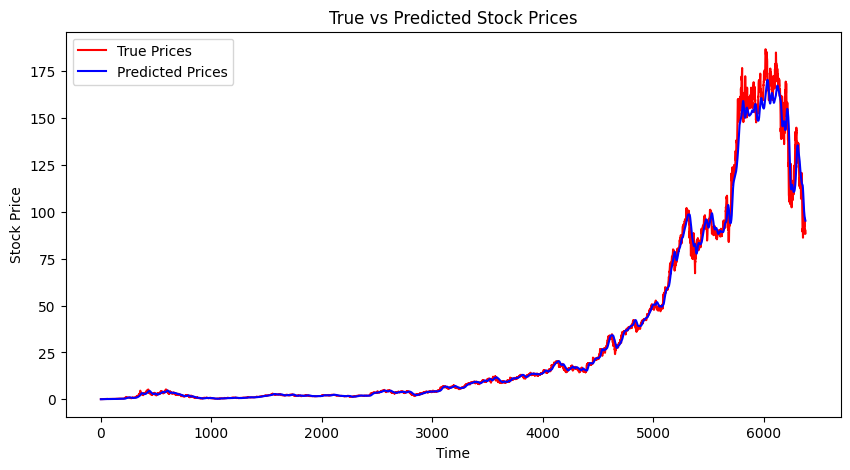

In [ ]:
# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(prices[-len(predicted_price):] - predicted_price))

# Print MAE
print("Mean Absolute Error (MAE):", mae)

# Visualize the true vs predicted stock prices
plt.figure(figsize=(10, 5))
plt.plot(prices[-len(predicted_price):], label='True Prices', color='red')
plt.plot(predicted_price, label='Predicted Prices', color='blue')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('True vs Predicted Stock Prices')
plt.show()


200/200 [==============================] - 10s 43ms/step


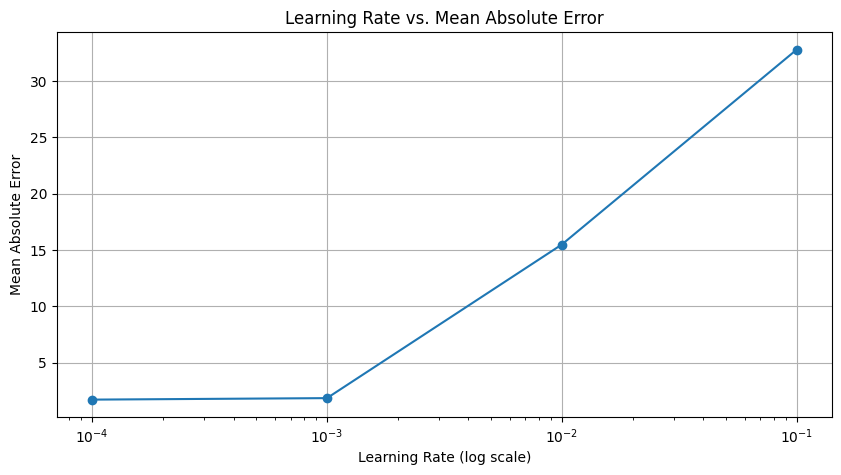

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

# List of learning rates to experiment with (in log scale)
learning_rates = [10**i for i in range(-4, 0)]  # e.g., [0.0001, 0.001, 0.01, 0.1]

# Initialize an array to store the mean absolute errors for each learning rate
mae_values = []

# Iterate over different learning rates
for lr in learning_rates:
    # Create the model and compile with the current learning rate
    custom_optimizer = Adam(learning_rate=lr)
    regressor.compile(optimizer=custom_optimizer, loss='mean_squared_error')

    # Train the model
    history = regressor.fit(x_train, y_train, epochs=10, batch_size=2048, verbose=0, validation_split=0.1)

    # Predict stock prices
    predicted_price = regressor.predict(x_test)
    predicted_price = sc.inverse_transform(predicted_price)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(prices[-len(predicted_price):], predicted_price)
    mae_values.append(mae)

# Plot learning rate versus Mean Absolute Error (MAE)
plt.figure(figsize=(10, 5))
plt.plot(learning_rates, mae_values, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Rate vs. Mean Absolute Error')
plt.grid(True)
plt.show()


200/200 [==============================] - 12s 49ms/step


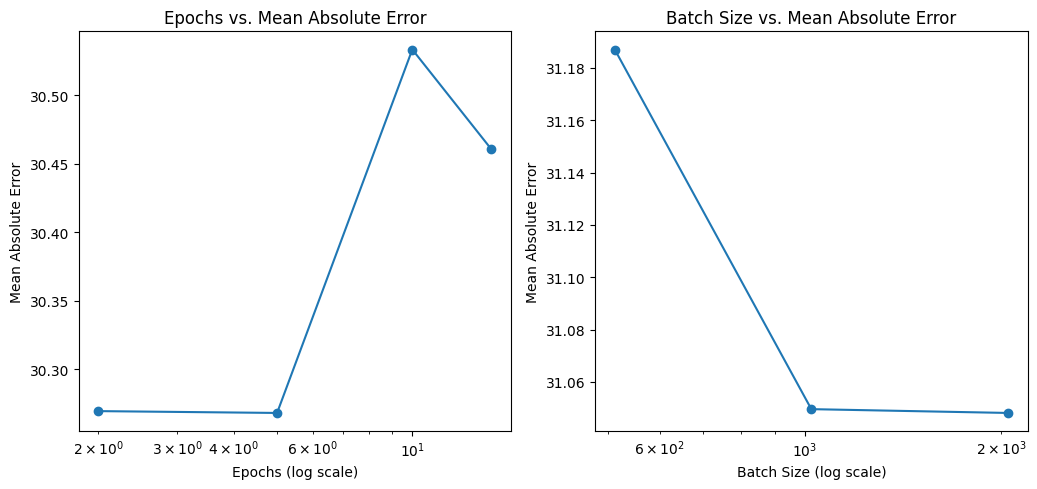

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

# List of learning rates, epochs, and batch sizes to experiment with
learning_rates = [10**i for i in range(-4, 0)]  # e.g., [0.0001, 0.001, 0.01, 0.1]
epochs_list = [2, 5, 10, 15]  # List of different epoch values to try
batch_sizes = [512, 1024, 2048]  # List of different batch sizes to try

# Initialize arrays to store the mean absolute errors for each parameter
mae_epochs = []
mae_batch_sizes = []

# Experiment with different epoch values
for epochs in epochs_list:
    regressor.compile(optimizer='adam', loss='mean_squared_error')

    history = regressor.fit(x_train, y_train, epochs=epochs, batch_size=512, verbose=0, validation_split=0.1)

    predicted_price = regressor.predict(x_test)
    predicted_price = sc.inverse_transform(predicted_price)

    mae = mean_absolute_error(prices[-len(predicted_price):], predicted_price)
    mae_epochs.append(mae)

# Experiment with different batch sizes
for batch_size in batch_sizes:
    regressor.compile(optimizer='adam', loss='mean_squared_error')

    history = regressor.fit(x_train, y_train, epochs=20, batch_size=batch_size, verbose=0, validation_split=0.1)

    predicted_price = regressor.predict(x_test)
    predicted_price = sc.inverse_transform(predicted_price)

    mae = mean_absolute_error(prices[-len(predicted_price):], predicted_price)
    mae_batch_sizes.append(mae)

# Plot learning rate versus Mean Absolute Error (MAE)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 2)
plt.plot(epochs_list, mae_epochs, marker='o')
plt.xscale('log')
plt.xlabel('Epochs (log scale)')
plt.ylabel('Mean Absolute Error')
plt.title('Epochs vs. Mean Absolute Error')

plt.subplot(1, 3, 3)
plt.plot(batch_sizes, mae_batch_sizes, marker='o')
plt.xscale('log')
plt.xlabel('Batch Size (log scale)')
plt.ylabel('Mean Absolute Error')
plt.title('Batch Size vs. Mean Absolute Error')

plt.tight_layout()
plt.show()
